In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.optimizer import Optimizer, required
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.utils as vutils
  
import argparse
import numpy as np
import os

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [ ]:
class Generator(nn.Module):
  def __init__(self,  z_dim, channels_img, features_g):
    super(Generator, self).__init__()

    self.z_dim = z_dim
    self.gen = nn.Sequential(
        #input: N x z_dim x 1 X 1
        #self._block(self, in_channels, out_channels, kernel_size, stride, padding)
        self._block(z_dim, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),

        nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),

        #Output: img N x channels_img x 64 x 64

        nn.Tanh() #[-1, 1]
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
      nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False
      ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()   
  )
    
  def forward(self, x):
    #return self.gen(x)
    return self.gen(x.view(-1, self.z_dim, 1, 1))

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()

    self.features_d = features_d
    self.w_g = 4
    self.fc = SpectralNorm(nn.Linear(self.w_g * self.w_g * features_d * 8 * 4, 1))

    self.disc = nn.Sequential(
        #input: N x channels_img x 64 x 64
        
        self._block(channels_img, features_d, 3, stride=1, padding=(1,1)),

        self._block(features_d, features_d, 4, stride=2, padding=(1,1)),
        self._block(features_d, features_d * 2, 3, stride=1, padding=(1,1)),

        self._block(features_d * 2, features_d * 2, 4, stride=2, padding=(1,1)),
        self._block(features_d * 2, features_d * 4, 3, stride=1, padding=(1,1)),

        self._block(features_d * 4, features_d * 4, 4, stride=2, padding=(1,1)),
        self._block(features_d * 4, features_d * 8, 3, stride=1, padding=(1,1))
        
        #self.fc
        # = SpectralNorm(nn.Linear(w_g * w_g * (features_d * 8), 1))
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        SpectralNorm(nn.Conv2d(
          in_channels,
          out_channels,
          kernel_size,
          stride,
          padding,
          bias=False
        )),
        nn.LeakyReLU(0.2)   
      )
    
  def forward(self, x):
    #return self.disc(x)

    m = x
    m = self.disc(x)
    return self.fc(m.view(-1,self.w_g * self.w_g * self.features_d * 8 * 4))

In [ ]:
#initialize weights according to the DC GAN paper

def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
def test():
  N, in_channels, H, W = 64, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))

  disc = Discriminator(in_channels, 64)
  #initialize_weights(disc)
  print(disc(x).shape)
  #assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
  #print("Discriminator test successfull")

  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
  print("Generator test successfull")
  print("Test succesfull")

In [ ]:
test()

torch.Size([64, 1])
Generator test successfull
Test succesfull


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
LEARNING_RATE_GEN = 2e-4  # could also use two lrs, one for gen and one for disc
LEARNING_RATE_DISC = 2e-4 
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
DISC_ITERS = 5

In [ ]:
print("Generator learning rate:", LEARNING_RATE_GEN)
print("Discriminator learning rate:", LEARNING_RATE_DISC)

Generator learning rate: 0.0002
Discriminator learning rate: 0.0002


In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ]
)

In [ ]:
dataset = datasets.MNIST(root="dataset/", train=True, transform = transform, download=True)

# comment mnist above and uncomment below if train on CelebA
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC)
gen.to(device)
disc.to(device)

Discriminator(
  (fc): SpectralNorm(
    (module): Linear(in_features=32768, out_features=1, bias=True)
  )
  (disc): Sequential(
    (0): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(128, 256,

In [ ]:
initialize_weights(gen)
#initialize_weights(disc)

In [ ]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN, betas=(0.0, 0.9))
opt_disc = optim.Adam(filter(lambda p: p.requires_grad, disc.parameters()), lr=LEARNING_RATE_DISC, betas=(0.0, 0.9))

In [ ]:
scheduler_d = optim.lr_scheduler.ExponentialLR(opt_disc, gamma=0.99)
scheduler_g = optim.lr_scheduler.ExponentialLR(opt_gen, gamma=0.99)

In [ ]:
fixed_z = torch.randn(32,Z_DIM, 1, 1).to(device)

In [ ]:
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")

In [ ]:
step = 0

In [ ]:
gen.train()
disc.train()

Discriminator(
  (fc): SpectralNorm(
    (module): Linear(in_features=32768, out_features=1, bias=True)
  )
  (disc): Sequential(
    (0): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): SpectralNorm(
        (module): Conv2d(128, 256,

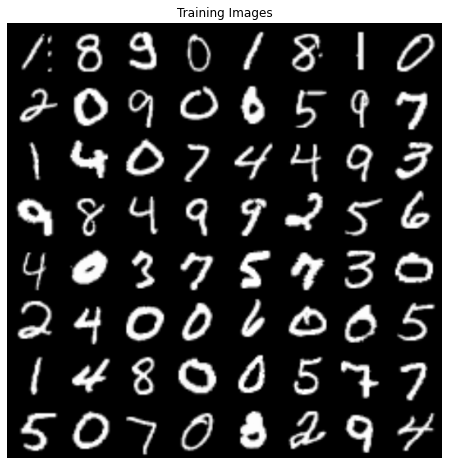

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
z = torch.randn(64, Z_DIM, 1, 1).to(device)

In [ ]:
gen(z).shape

torch.Size([64, 1, 64, 64])

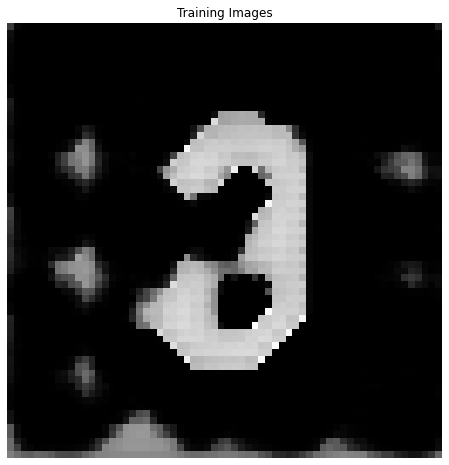

In [ ]:
z = torch.randn(64, Z_DIM, 1, 1).to(device)
fake_batch = gen(z)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

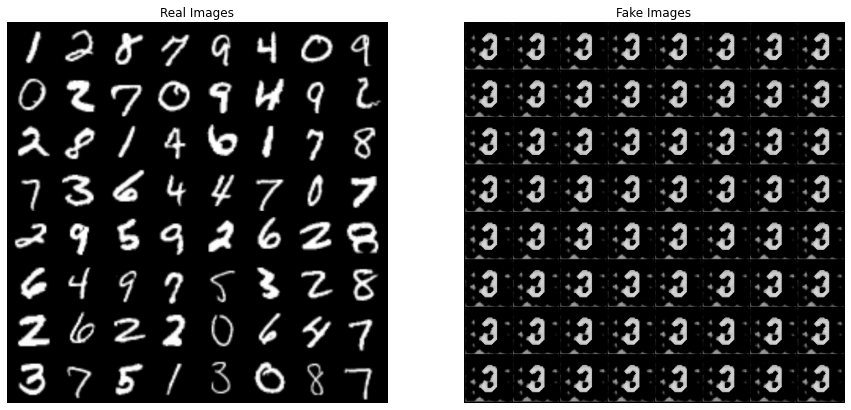

Epoch [0/5] Batch 0/469 \ Loss D: -1500.7834, loss G: -4251.0952
Epoch [0/5] Batch 25/469 \ Loss D: -1949.5649, loss G: -3518.6775
Epoch [0/5] Batch 50/469 \ Loss D: -1352.6682, loss G: -3676.4331
Epoch [0/5] Batch 75/469 \ Loss D: -1451.5908, loss G: -4933.4375
Epoch [0/5] Batch 100/469 \ Loss D: -1513.9771, loss G: -4047.6174
Epoch [0/5] Batch 125/469 \ Loss D: -1371.4641, loss G: -3229.7578
Epoch [0/5] Batch 150/469 \ Loss D: -2330.9746, loss G: -1156.5906
Epoch [0/5] Batch 175/469 \ Loss D: -637.9976, loss G: -5341.1631
Epoch [0/5] Batch 200/469 \ Loss D: -315.5889, loss G: -3087.6089
Epoch [0/5] Batch 225/469 \ Loss D: -347.5895, loss G: -1210.5778
Epoch [0/5] Batch 250/469 \ Loss D: -1408.1274, loss G: -4050.8564
Epoch [0/5] Batch 275/469 \ Loss D: -670.1648, loss G: -3342.5876
Epoch [0/5] Batch 300/469 \ Loss D: 34.9731, loss G: -442.3286
Epoch [0/5] Batch 325/469 \ Loss D: -232.7363, loss G: -3109.6401
Epoch [0/5] Batch 350/469 \ Loss D: -295.7808, loss G: -2793.1453
Epoch [0/5

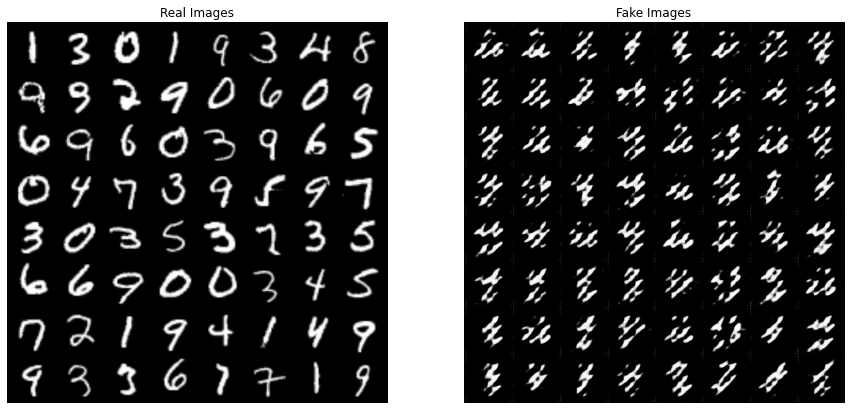

Epoch [1/5] Batch 0/469 \ Loss D: -221.4319, loss G: -1276.2915
Epoch [1/5] Batch 25/469 \ Loss D: -306.2926, loss G: -1383.3256
Epoch [1/5] Batch 50/469 \ Loss D: -316.7510, loss G: -184.2568
Epoch [1/5] Batch 75/469 \ Loss D: -296.1458, loss G: -1510.9181
Epoch [1/5] Batch 100/469 \ Loss D: -157.0056, loss G: 133.7727
Epoch [1/5] Batch 125/469 \ Loss D: -243.6320, loss G: 635.0825
Epoch [1/5] Batch 150/469 \ Loss D: -99.2925, loss G: -3242.4019
Epoch [1/5] Batch 175/469 \ Loss D: -30.7451, loss G: -4008.9902
Epoch [1/5] Batch 200/469 \ Loss D: -357.5288, loss G: 1391.9092
Epoch [1/5] Batch 225/469 \ Loss D: -164.3584, loss G: 3578.7288
Epoch [1/5] Batch 250/469 \ Loss D: -202.9233, loss G: -3391.1106
Epoch [1/5] Batch 275/469 \ Loss D: 86.1831, loss G: -4773.7217
Epoch [1/5] Batch 300/469 \ Loss D: -34.7349, loss G: -1489.3672
Epoch [1/5] Batch 325/469 \ Loss D: -374.0430, loss G: -5948.8169
Epoch [1/5] Batch 350/469 \ Loss D: -105.9436, loss G: -3218.6929
Epoch [1/5] Batch 375/469 \

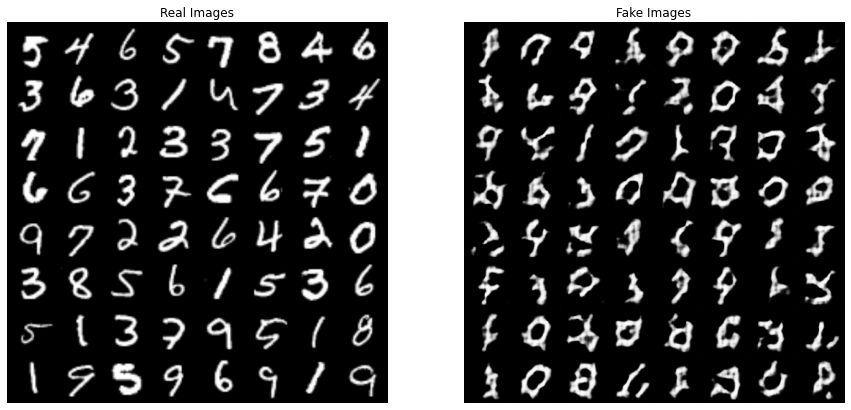

Epoch [2/5] Batch 0/469 \ Loss D: -60.8975, loss G: -243.2715
Epoch [2/5] Batch 25/469 \ Loss D: -115.9933, loss G: 782.1803
Epoch [2/5] Batch 50/469 \ Loss D: 13.0977, loss G: -4664.6211
Epoch [2/5] Batch 75/469 \ Loss D: -126.8859, loss G: 584.3362
Epoch [2/5] Batch 100/469 \ Loss D: -648.6274, loss G: -7060.6865
Epoch [2/5] Batch 125/469 \ Loss D: -138.7328, loss G: -842.8591
Epoch [2/5] Batch 150/469 \ Loss D: -133.4136, loss G: 2125.8657
Epoch [2/5] Batch 175/469 \ Loss D: 63.1501, loss G: -3275.7827
Epoch [2/5] Batch 200/469 \ Loss D: -139.0166, loss G: -5101.8096
Epoch [2/5] Batch 225/469 \ Loss D: -3.9112, loss G: 121.6051
Epoch [2/5] Batch 250/469 \ Loss D: -58.7119, loss G: -3904.0522
Epoch [2/5] Batch 275/469 \ Loss D: -74.6426, loss G: -3238.6475
Epoch [2/5] Batch 300/469 \ Loss D: -80.6709, loss G: -5483.9023
Epoch [2/5] Batch 325/469 \ Loss D: 31.2250, loss G: -748.9016
Epoch [2/5] Batch 350/469 \ Loss D: -26.7312, loss G: -2477.4919
Epoch [2/5] Batch 375/469 \ Loss D: -4

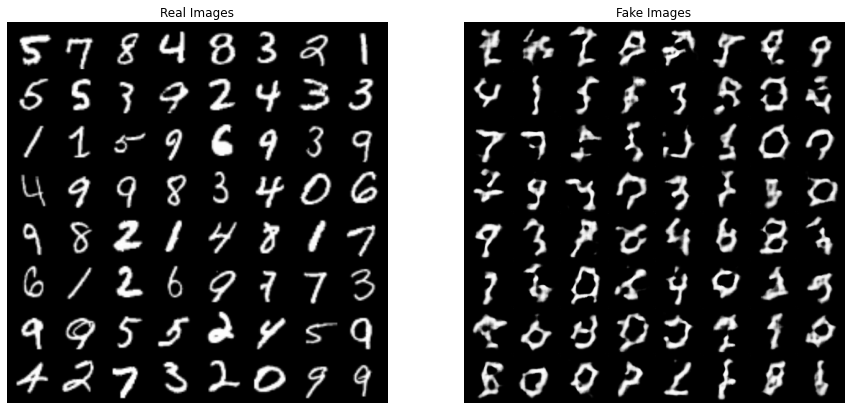

Epoch [3/5] Batch 0/469 \ Loss D: -83.8262, loss G: -5040.8184
Epoch [3/5] Batch 25/469 \ Loss D: -234.0833, loss G: 2325.1536
Epoch [3/5] Batch 50/469 \ Loss D: -48.7832, loss G: -4515.3706
Epoch [3/5] Batch 75/469 \ Loss D: -204.2330, loss G: 762.4633
Epoch [3/5] Batch 100/469 \ Loss D: -266.7524, loss G: -7581.9453
Epoch [3/5] Batch 125/469 \ Loss D: 29.7954, loss G: -4048.3105
Epoch [3/5] Batch 150/469 \ Loss D: -120.6747, loss G: -23.9002
Epoch [3/5] Batch 175/469 \ Loss D: -102.3888, loss G: 1944.6125
Epoch [3/5] Batch 200/469 \ Loss D: -50.9868, loss G: -2798.0085
Epoch [3/5] Batch 225/469 \ Loss D: -27.6904, loss G: -973.5968
Epoch [3/5] Batch 250/469 \ Loss D: 33.9648, loss G: -4489.2944
Epoch [3/5] Batch 275/469 \ Loss D: -20.7797, loss G: -1395.9453
Epoch [3/5] Batch 300/469 \ Loss D: -63.3875, loss G: 2986.6570
Epoch [3/5] Batch 325/469 \ Loss D: -65.1829, loss G: -3428.3159
Epoch [3/5] Batch 350/469 \ Loss D: 13.0612, loss G: 1054.4207
Epoch [3/5] Batch 375/469 \ Loss D: -

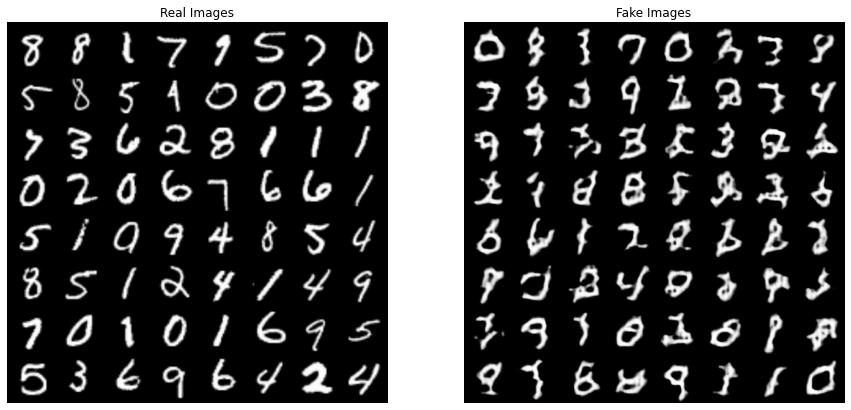

Epoch [4/5] Batch 0/469 \ Loss D: -375.4326, loss G: -6706.8716
Epoch [4/5] Batch 25/469 \ Loss D: -35.1546, loss G: 561.5897
Epoch [4/5] Batch 50/469 \ Loss D: -29.0464, loss G: -3328.9690
Epoch [4/5] Batch 75/469 \ Loss D: -87.5671, loss G: -2001.0143
Epoch [4/5] Batch 100/469 \ Loss D: -138.4131, loss G: -6572.8301
Epoch [4/5] Batch 125/469 \ Loss D: -205.3047, loss G: 3181.0669
Epoch [4/5] Batch 150/469 \ Loss D: -73.0835, loss G: -4085.7803
Epoch [4/5] Batch 175/469 \ Loss D: -68.9804, loss G: -458.9804
Epoch [4/5] Batch 200/469 \ Loss D: -141.8823, loss G: 3189.6724
Epoch [4/5] Batch 225/469 \ Loss D: -43.4210, loss G: -2486.7986
Epoch [4/5] Batch 250/469 \ Loss D: -186.8606, loss G: 2125.3252
Epoch [4/5] Batch 275/469 \ Loss D: -130.4209, loss G: -6396.9951
Epoch [4/5] Batch 300/469 \ Loss D: -183.6514, loss G: -5246.0049
Epoch [4/5] Batch 325/469 \ Loss D: -351.3848, loss G: 4054.9263


In [ ]:
for epoch in range(NUM_EPOCHS):

  real_batch = next(iter(dataloader))

  # Plot the real images
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

  img_list = []
  z = torch.randn(64, Z_DIM, 1, 1).to(device)
  fake = gen(z).detach().cpu()

  img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

  # Plot the fake images from the last epoch
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(img_list[-1],(1,2,0)))
  plt.show()

  for batch_index, (real, _) in enumerate(dataloader):

    if real.size()[0] != BATCH_SIZE:
            continue

    #update discriminator
    for _ in range (DISC_ITERS):

      real = real.to(device)
      z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
      fake = gen(z)

      disc.zero_grad()
      gen.zero_grad()

      #loss = 'wasserstein'
      disc_loss = -disc(real).mean() + disc(gen(z)).mean()

      disc_loss.backward()
      opt_disc.step()
    
    z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)

    disc.zero_grad()
    gen.zero_grad()    

    gen_loss = -disc(gen(z)).mean()

    gen_loss.backward()
    opt_gen.step()

    if batch_index % 25 == 0:
      print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_index}/{len(dataloader)} \ Loss D: {disc_loss:.4f}, loss G: {gen_loss:.4f}")

    #scheduler_d.step()
    #scheduler_g.step()

  #Plot some generated images at the end of each epoch
  

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

img_list = []
z = torch.randn(64, Z_DIM, 1, 1).to(device)
fake = gen(z).detach().cpu()

img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

NameError: ignored